ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    name = 'NINST'; format = '3J'
    name = 'NVISITS'; format = 'J'
    name = 'COMBTYPE'; format = 'J'
    name = 'COMMISS'; format = 'I'
    name = 'SNR'; format = 'E'
    name = 'STARFLAG'; fo

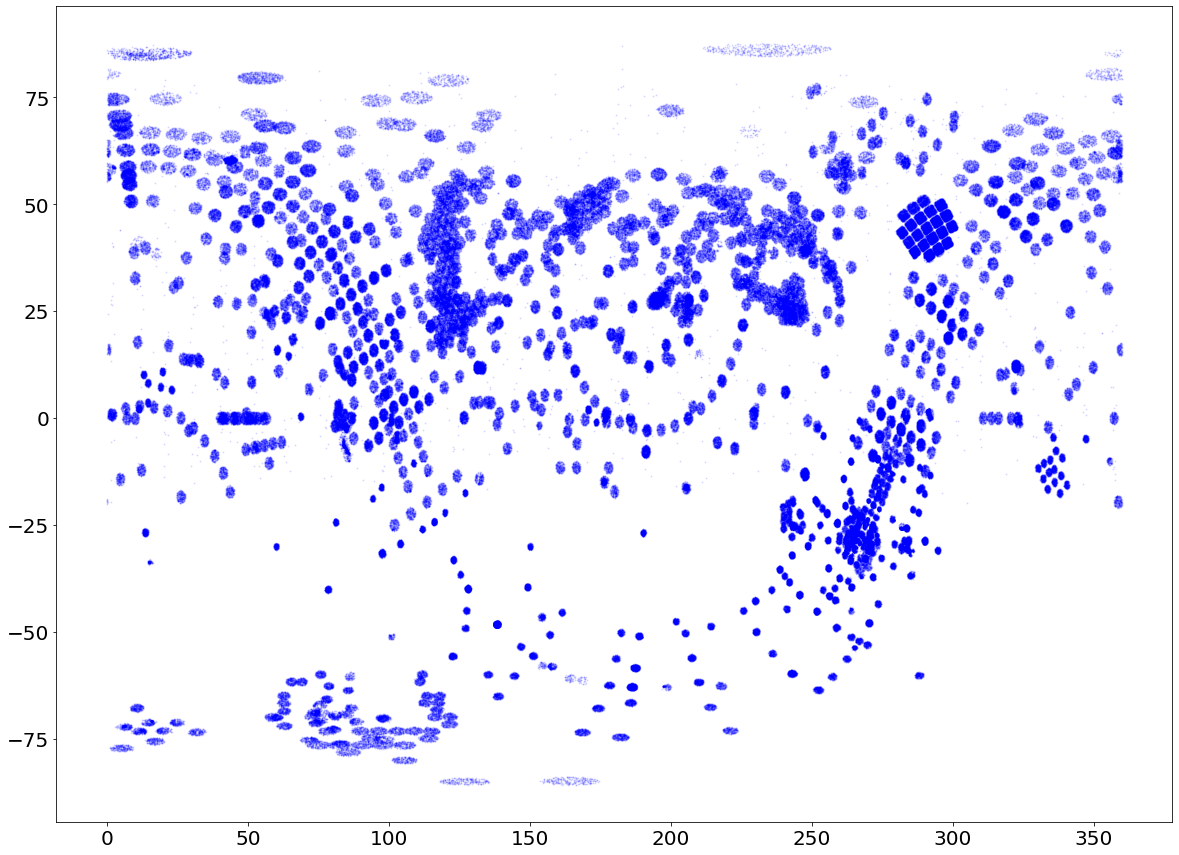

In [36]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def cosfit1 (x,a,b,c,d):
    return a*np.cos(2*np.pi*b*x + c) + d 

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gausian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

# a) stars with 1 < GLAT < 1
# TEFF, (TEFF ERR) vs. LogG (LOGG ERR)

-2.0670746635534604e-07 0.0032843268235821397 -8.428369513286208
9.56417164120463e-08 -0.0012205219102468768 8.025660287127124


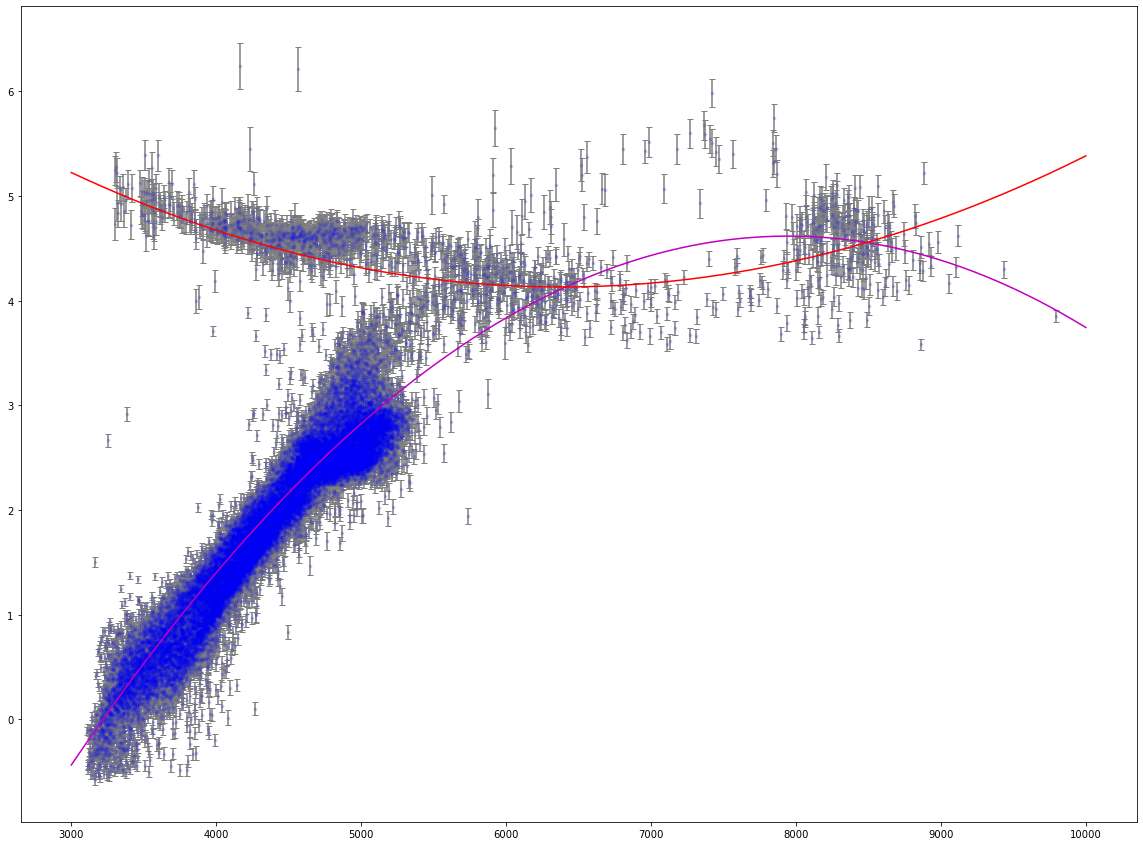

In [69]:
gd1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] >= -1) & (star['GLAT'] <= 1) & (star['TEFF'] > 0) & (star['LOGG'] > -200)
good1 = np.where(gd1)[0]

def mcFit(x, x_err, y, y_err):
    a = list()
    b = list()
    c = list()
    #d = list()
    iters = 500
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        params, other = opt.curve_fit(poly2, x_adj, y_adj)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
    
    return a, b, c

sa, sb, sc = mcFit(star['TEFF'][good1], star['TEFF_ERR'][good1], star['LOGG'][good1], star['LOGG_ERR'][good1])
print(np.mean(sa), np.mean(sb), np.mean(sc))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['TEFF'][good1], star['LOGG'][good1], s=10,c='b',alpha=0.1)
ax.errorbar(star['TEFF'][good1], star['LOGG'][good1], yerr = star['LOGG_ERR'][good1], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(3000,10000,10000)
ax.plot(x, poly2(x, np.mean(sa), np.mean(sb), np.mean(sc)), label='MC', c = 'm')

gd11 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
     (star['GLAT'] >= -1) & (star['GLAT'] <= 1) & (star['TEFF'] > 0) & (star['LOGG'] > -200) & (star['LOGG'] > 3.5)
good11 = np.where(gd11)[0]

def mcFit(x, x_err, y, y_err):
    a = list()
    b = list()
    c = list()
    iters = 500
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        param, other = opt.curve_fit(poly2, x_adj, y_adj)
        a.append(param[0])
        b.append(param[1])
        c.append(param[2])
    
    return a, b, c

sa1, sb1, sc1 = mcFit(star['TEFF'][good11], star['TEFF_ERR'][good11], star['LOGG'][good11], star['LOGG_ERR'][good11])
print(np.mean(sa1), np.mean(sb1), np.mean(sc1))
ax.plot(x, poly2(x, np.mean(sa1), np.mean(sb1), np.mean(sc1)), label='MC', c = 'r')


# b) stars with GLAT < −10 or GLAT > 10 
# Fe H, (Fe H ERR) vs. O FE (O FE ERR)

-0.29908691547109134 6.684393001299028 -0.2720932384792063 0.2535473469694908


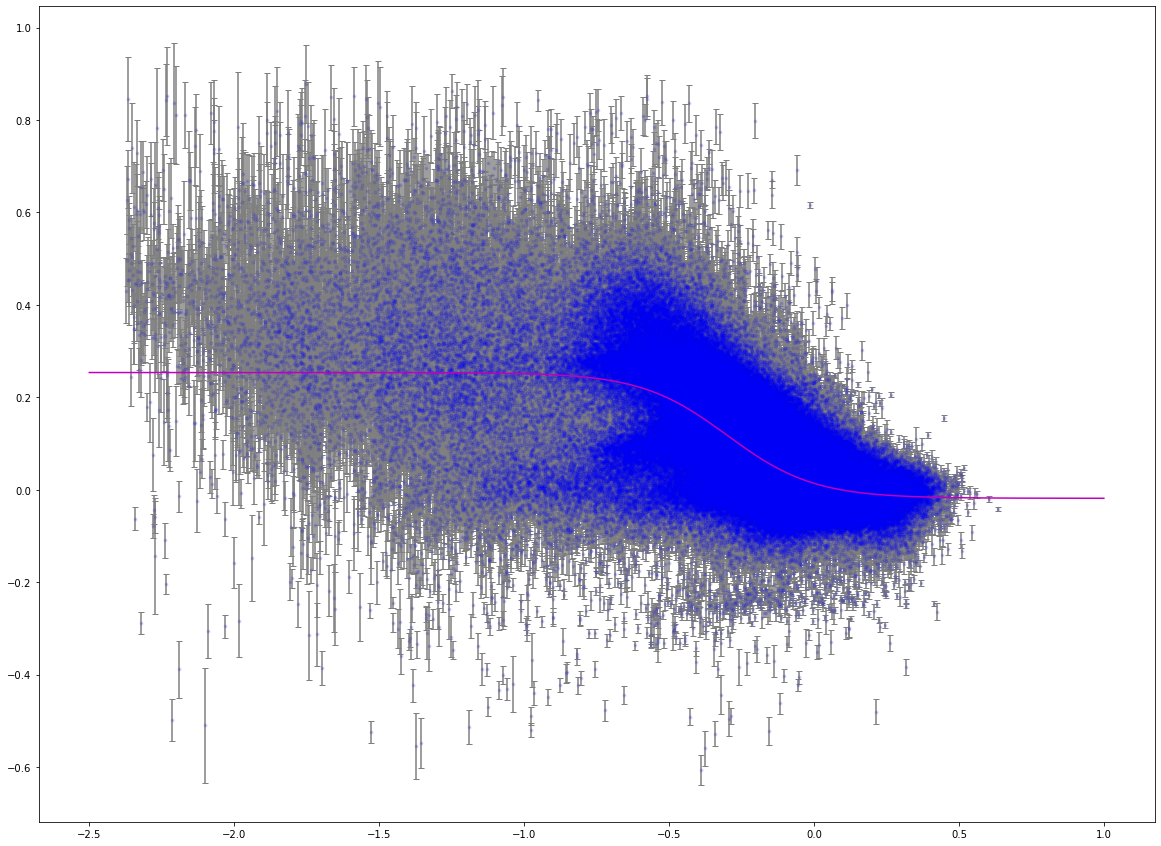

In [71]:
gd2 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & (np.absolute(star['GLAT']) > 10) & (star['O_FE'] > -2000)
good2 = np.where(gd2)[0]

def mcFit(x, x_err, y, y_err):
    a = list()
    b = list()
    c = list()
    d = list()
    iters = 50
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        params, other = opt.curve_fit(sigmoid, x_adj, y_adj)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
    
    return a, b, c, d

sa, sb, sc, sd = mcFit(star['FE_H'][good2], star['FE_H_ERR'][good2], star['O_FE'][good2], star['O_FE_ERR'][good2])
print(np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['FE_H'][good2], star['O_FE'][good2], s=10,c='b',alpha=0.1)
ax.errorbar(star['FE_H'][good2], star['O_FE'][good2], yerr = star['O_FE_ERR'][good2], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(-2.5,1,1000)
ax.plot(x, sigmoid(x, np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd)), label='MC', c = 'm')

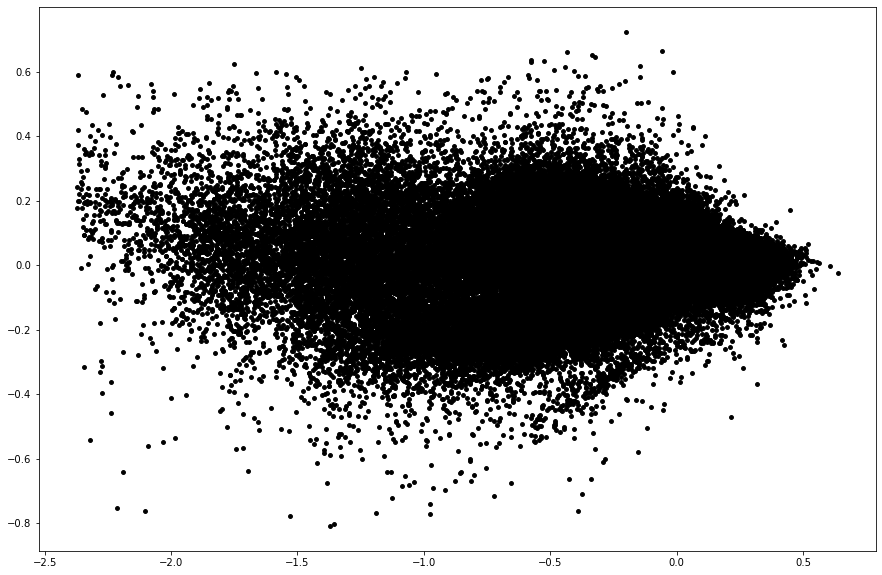

In [72]:
residual = star['O_FE'][good2]-sigmoid(star['O_FE'][good2], np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd)) #how far real from our fit (how bad or good is our fit)
x = np.linspace(-2.5,1,1000)

fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(111)
ax2.scatter(star['FE_H'][good2],(star['O_FE'][good2]-sigmoid(star['FE_H'][good2], np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd))),s=15,c='black')


# c) stars only with with −2 < GLAT < 2
# Fe H, (Fe H ERR) vs. O FE (O FE ERR)


0.11439592822880178 0.16693536126769984 -0.1483903359628265 0.0312517206101344
-0.4209807184401916 9.93108732811018 -0.06277819013703084 0.27460603869722894


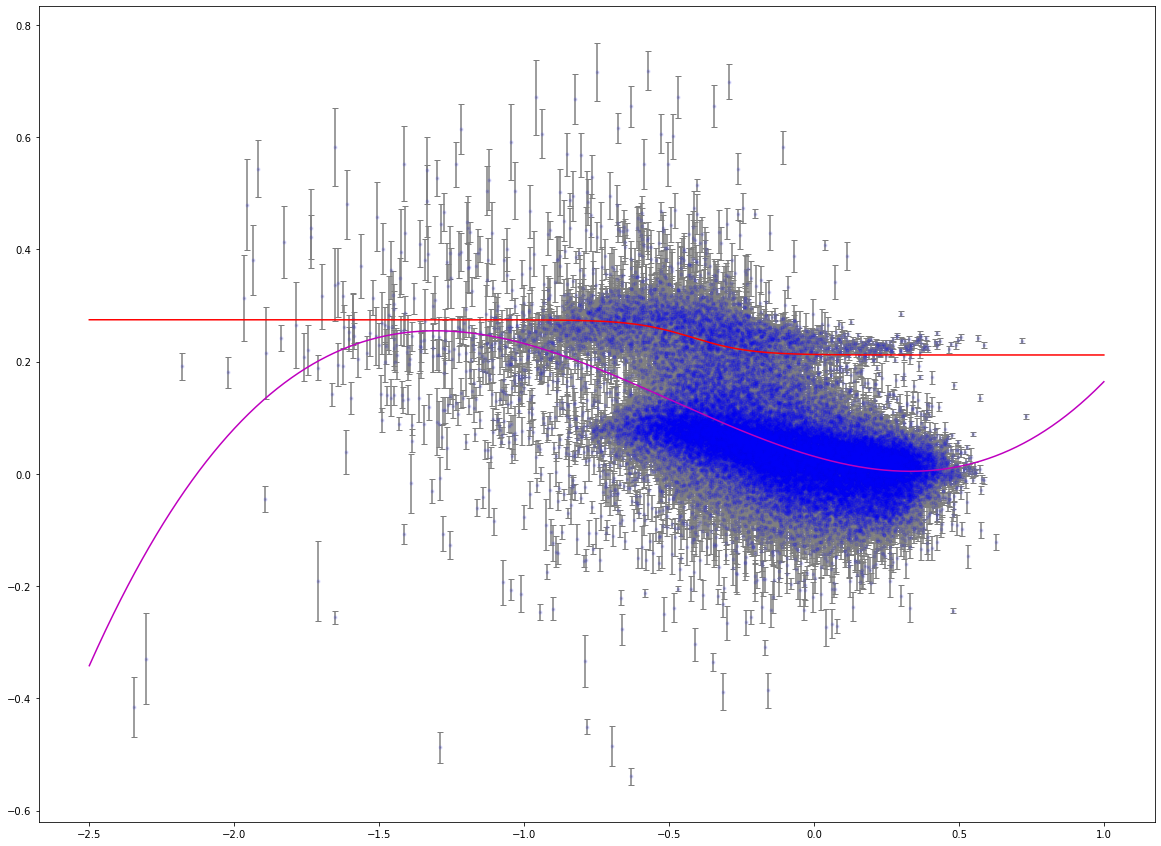

In [97]:
gd3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & (star['GLAT'] >= -2) & (star['GLAT'] <= 2) & (star['O_FE'] > -2000)
good3 = np.where(gd3)[0]

def mcFit(x, x_err, y, y_err):
    a = list()
    b = list()
    c = list()
    d = list()
    iters = 500
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        params, other = opt.curve_fit(poly3, x_adj, y_adj)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
    
    return a, b, c, d

sa, sb, sc, sd = mcFit(star['FE_H'][good3], star['FE_H_ERR'][good3], star['O_FE'][good3], star['O_FE_ERR'][good3])
print(np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['FE_H'][good3], star['O_FE'][good3], s=10,c='b',alpha=0.1)
ax.errorbar(star['FE_H'][good3], star['O_FE'][good3], yerr = star['O_FE_ERR'][good3], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(-2.5,1,1000)
ax.plot(x, poly3(x, np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd)), label='MC', c = 'm')

gd33 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & (star['GLAT'] >= -2) & (star['GLAT'] <= 2) & (star['O_FE'] > -2000) & (star['O_FE'] > 0.15)
good33 = np.where(gd33)[0]

def mcFit(x, x_err, y, y_err):
    a = list()
    b = list()
    c = list()
    d = list()
    iters = 50
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        params, other = opt.curve_fit(sigmoid, x_adj, y_adj)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
    
    return a, b, c, d

sa1, sb1, sc1, sd1 = mcFit(star['FE_H'][good33], star['FE_H_ERR'][good33], star['O_FE'][good33], star['O_FE_ERR'][good33])
print(np.mean(sa1), np.mean(sb1), np.mean(sc1), np.mean(sd1))
ax.plot(x, sigmoid(x, np.mean(sa1), np.mean(sb1), np.mean(sc1), np.mean(sd1)), label='MC', c = 'r')



# d) stars with GLAT < −10 or GLAT > 10
# TEFF, (TEFF ERR) vs. (J - K) (J ERR, K ERR)

4.1857391650739604e-08 -0.0007045961507092887 3.094535261391229


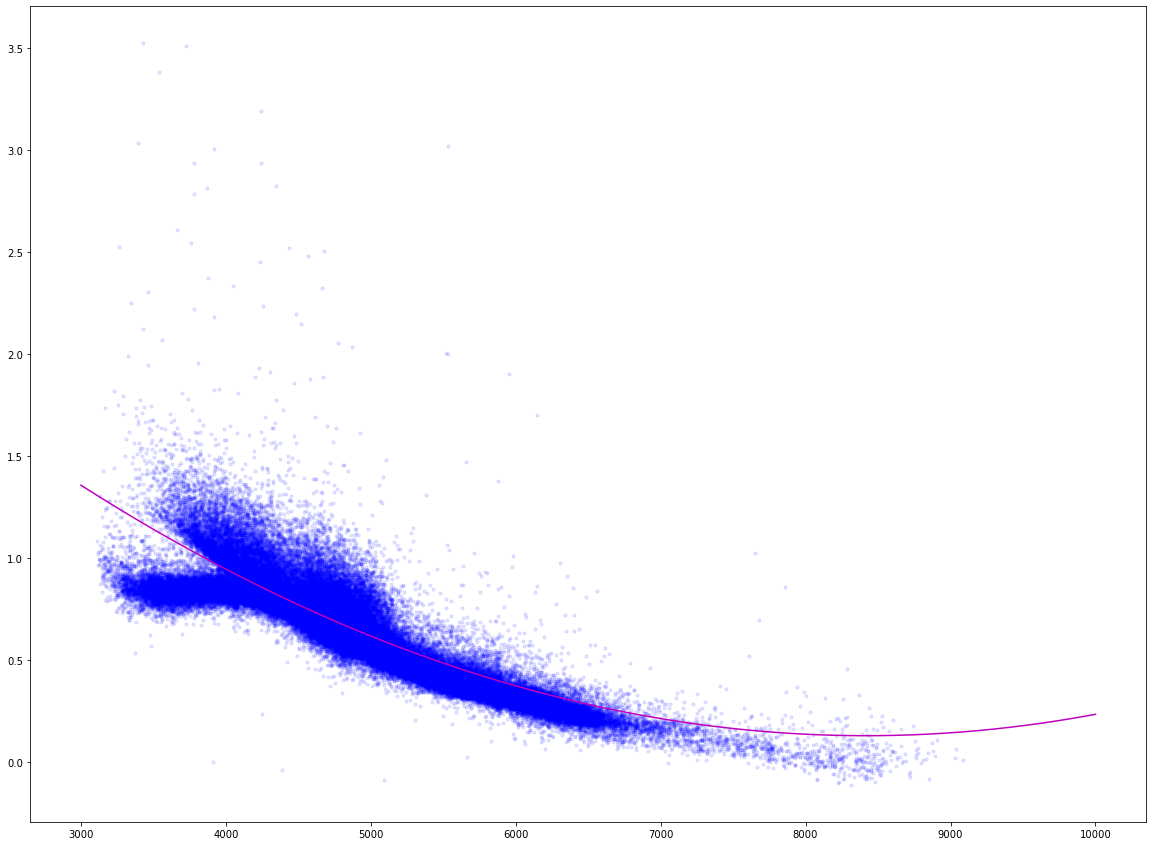

In [99]:
gd4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & np.absolute(star['GLAT'] >= 10)  & (star['J']-star['K'] < 1000) & (star['TEFF'] > 0)
good4 = np.where(gd4)[0]

def mcFit(x, x_err, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    
    iters = 500
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsx
        x_adj = x + x_err*weightsy

        params, other = opt.curve_fit(poly2, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        
    return a, b, c

K_err = star['K_ERR'][good4]
J_err = star['J_ERR'][good4]
err = np.sqrt(K_err**2 + J_err**2)
J = star['J'][good4]
K = star['K'][good4]
              
sa, sb, sc = mcFit(star['TEFF'][good4], star['TEFF_ERR'][good4], J-K, err, [1,1,1])
print(np.mean(sa), np.mean(sb), np.mean(sc))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['TEFF'][good4],J-K, s=10,c='b',alpha=0.1)
#ax.errorbar(star['TEFF'][good4], J-K, yerr = err, c='tab:gray', 
            #fmt='.', markersize=1, capsize=3 ,zorder=0)

x = np.linspace(3000,10000,1000)
ax.plot(x, poly2(x, np.mean(sa), np.mean(sb), np.mean(sc)), label='MC', c = 'm')

# e) stars with −10 < GLAT < 10
# GLON vs. VHEILO AVG (VERR)

56.15241783371161 0.022694848572638864 13.347617966869205 1.2344050556507846


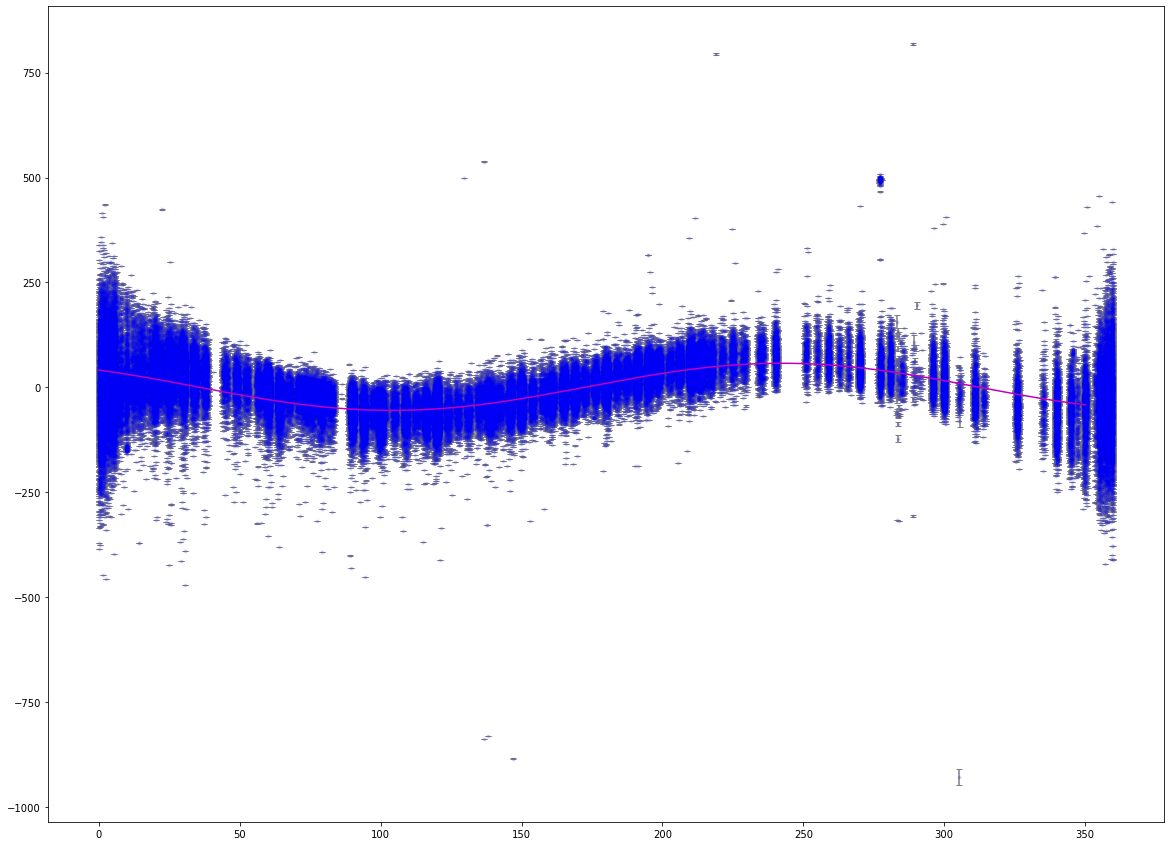

In [109]:
gd5 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
    (np.bitwise_and(star['starflag'], suspectbits) == 0) & (star['GLAT'] >= -10) & (star['GLAT'] <= 10)


def mcFit(x, y, y_err, p0):
    a = list()
    b = list()
    c = list()
    d = list()
    iters = 50
    for i in range(iters):  
        weightsy = np.random.randn(len(y)) 

        y_adj = y + y_err*weightsy
        x_adj = x

        params, other = opt.curve_fit(cosfit, x_adj, y_adj, p0=p0)
        a.append(params[0])
        b.append(params[1])
        c.append(params[2])
        d.append(params[3])
    
    return a, b, c, d

sa, sb, sc, sd = mcFit(star['GLON'][good5], star['VHELIO_AVG'][good5], star['VERR'][good5], [50,0.022,13,1])
print(np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['GLON'][good5], star['VHELIO_AVG'][good5], s=10,c='b',alpha=0.1)
ax.errorbar(star['GLON'][good5], star['VHELIO_AVG'][good5], yerr = star['VERR'][good5], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(0,350,10000)
ax.plot(x, cosfit(x, np.mean(sa), np.mean(sb), np.mean(sc), np.mean(sd)), label='MC', c = 'm')


# f) NVISITS vs. VSCATTER (VERR), for NVISITS >= 1


0.05238587841237342 0.11377950286751787


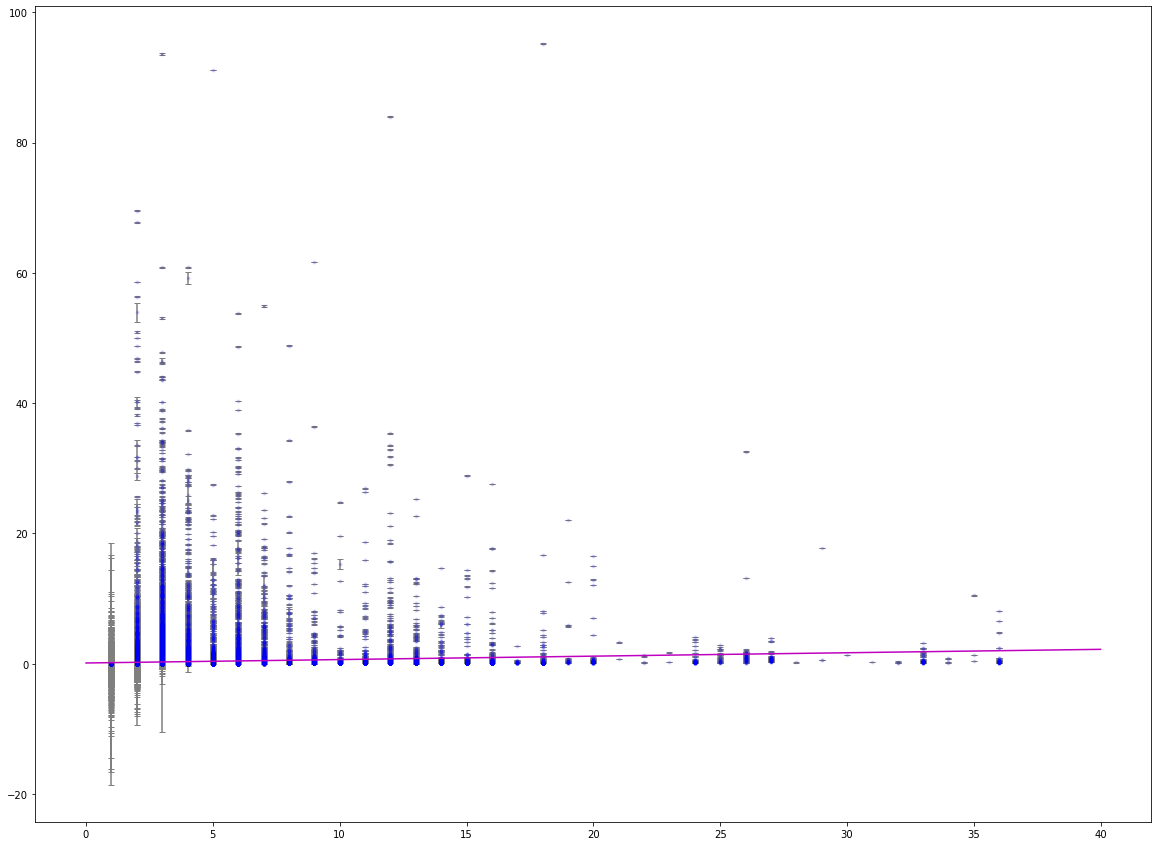

In [104]:
gd6 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
    (np.bitwise_and(star['starflag'], suspectbits) == 0) & (star['GLAT'] >= -10) & (star['GLAT'] <= 10) & (star['NVISITS'] >= 1) 
good6 = np.where(gd6)[0]


def mcFit(x, y, y_err):
    m = list()
    b = list()
    iters = 50
    for i in range(iters):
        weightsx = np.random.randn(len(y))   
        
        y_adj = y + y_err*weightsx
        x_adj = x

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        m.append(params[0])
        b.append(params[1])
    
    return m, b

sm, sb = mcFit(star['NVISITS'][good6], star['VSCATTER'][good6], star['VERR'][good6])
print(np.mean(sm), np.mean(sb))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['NVISITS'][good6], star['VSCATTER'][good6], s=10,c='b',alpha=0.1)
ax.errorbar(star['NVISITS'][good6], star['VSCATTER'][good6], yerr = star['VERR'][good6], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(0,40,1000)
ax.plot(x, linear(x, np.mean(sm), np.mean(sb)), label='MC', c = 'm')

# g) Fe H, (Fe H ERR) vs. NI FE (NI FE ERR)

0.00558808430379786 0.026209096980373502


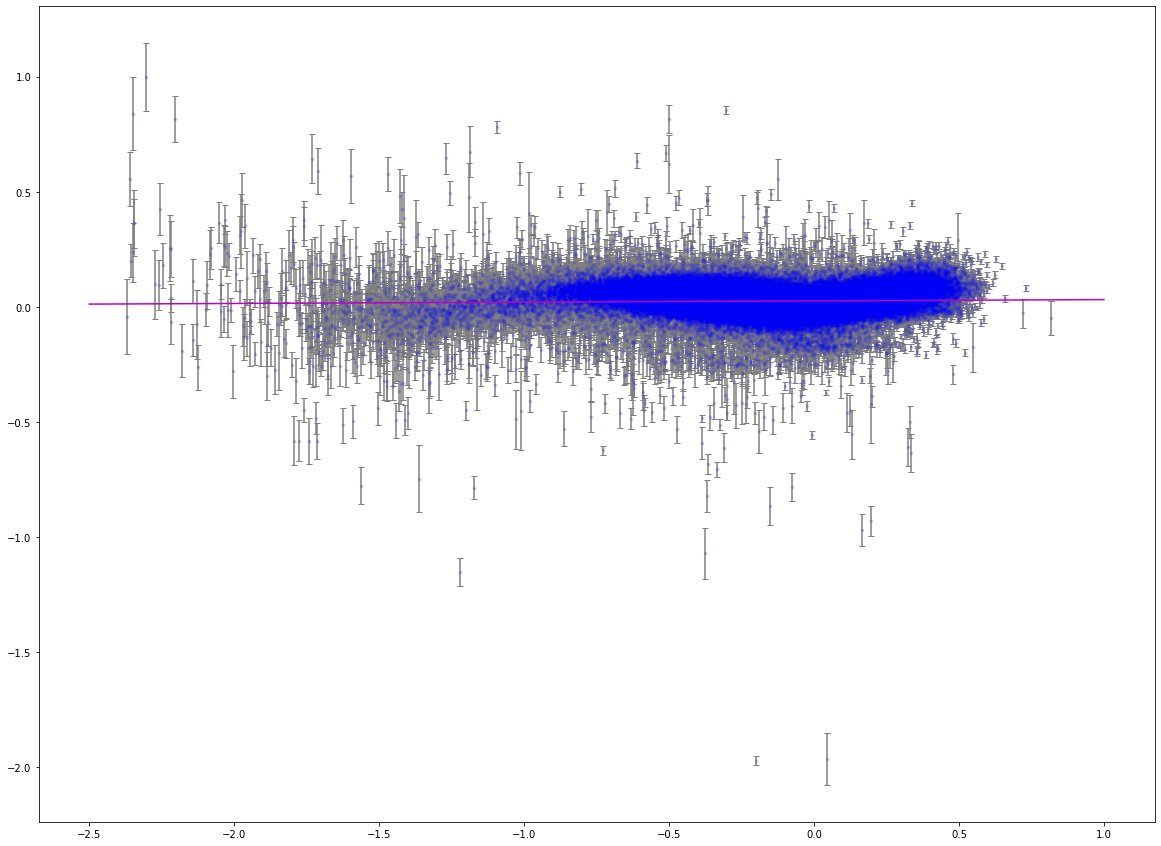

In [105]:
gd7 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
    (np.bitwise_and(star['starflag'], suspectbits) == 0) & (star['GLAT'] >= -10) & (star['GLAT'] <= 10) & (star['NI_FE'] > -2000) 
good7 = np.where(gd7)[0]

def mcFit(x, x_err, y, y_err):
    m = list()
    b = list()
    iters = 5
    for i in range(iters):
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        m.append(params[0])
        b.append(params[1])
        #c.append(params[2])
        #d.append(params[3])
    
    return m, b

sm, sb = mcFit(star['FE_H'][good7], star['FE_H_ERR'][good7], star['NI_FE'][good7], star['NI_FE_ERR'][good7])
print(np.mean(sm), np.mean(sb))

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['FE_H'][good7], star['NI_FE'][good7], s=10,c='b',alpha=0.1)
ax.errorbar(star['FE_H'][good7], star['NI_FE'][good7], yerr = star['NI_FE_ERR'][good7], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)
x = np.linspace(-2.5,1,1000)
ax.plot(x, linear(x, np.mean(sm), np.mean(sb)), label='MC', c = 'm')
